# Modeling

### Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lightgbm as lgb
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.sparse import hstack


### Load the sampled DataFrame

In [3]:
df = pd.read_pickle("cleaned_reviews.pkl")

print(df.shape)
print(df.head())

(1000000, 13)
   rating                                        title  \
0     3.0            Smells like gasoline! Going back!   
1     1.0      Didn’t work at all lenses loose/broken.   
2     5.0                                   Excellent!   
3     5.0                       Great laptop backpack!   
4     5.0  Best Headphones in the Fifties price range!   

                                                text  \
0  first  most offensive they reek of gasoline so...   
1  these didnt work idk if they were damaged in s...   
2  i love these they even come with a carry case ...   
3  i was searching for a sturdy backpack for scho...   
4  ive bought these headphones three times becaus...   

                                              images        asin parent_asin  \
0  [{'attachment_type': 'IMAGE', 'large_image_url...  B083NRGZMM  B083NRGZMM   
1                                                 []  B07N69T6TM  B07N69T6TM   
2                                                 []  B01G8J

In [4]:
df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'sentiment_polarity',
       'sentiment_category', 'duplicated_review'],
      dtype='object')

In [ ]:
# Find all duplicated reviews (not just the first occurrence)
duplicated_reviews = df[df.duplicated(subset=["text"], keep=False)]

print(duplicated_reviews[["text", "user_id", "asin"]].head(10))

                            text                       user_id        asin
8      pretty good for the price  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B002HWRZ2K
44                 fast charging  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  B07PGRR6QN
50   works great easy to install  AHITBJSS7KYUBVZPX7M2WJCOIVKQ  B00EVVGAFI
61     works great no complaints  AFVNEEPDEIH5SPUN5BWC6NKL3WNQ  B0714NB5TL
64                       awesome  AHXSBZT52TCPZUBVCBRICTHWUCBA  B0045DT3A6
67                          gift  AHBHMMUTJ5W3SZUHVKUP35ZYKUHA  B0733GXPYZ
77                       love it  AHZIJGKEWRTAEOZ673G5B3SNXEGQ  B07PGL2N7J
98           great little device  AEFKF6R2GUSK2AWPSWRR4ZO36JVQ  B01KWY71BO
99                 good warranty  AEFKF6R2GUSK2AWPSWRR4ZO36JVQ  B008I64LC6
127         just what was needed  AFWHJ6O3PV4JC7PVOJH6CPULO2KQ  B00M77HMU0


In [6]:
print(df["text"].value_counts().head(10))

works great      5066
great            4149
good             3898
great product    2999
love it          2785
excellent        1806
good product     1790
perfect          1743
ok               1650
works well       1412
Name: text, dtype: int64


In [7]:
# Add a column: 1 if user posted the same review text for different products, else 0 (suspicious user)
user_text_multi_products = (
    df.groupby(["user_id", "text"])["asin"].nunique().reset_index()
)
user_text_multi_products["suspicious_user"] = (user_text_multi_products["asin"] > 1).astype(int)

# Merge this info back to the main DataFrame
df = df.merge(
    user_text_multi_products[["user_id", "text", "suspicious_user"]],
    on=["user_id", "text"],
    how="left"
)
df["suspicious_user"] = df["suspicious_user"].fillna(0).astype(int)

print(df["suspicious_user"].value_counts())

0    952798
1     47202
Name: suspicious_user, dtype: int64


### Labeling

In [ ]:
# Create a heuristic label for fake reviews

# Heuristic 1: User is suspicious (posted same review for multiple products)
# Heuristic 2: Review is not a verified purchase and has 0 helpful votes
# Heuristic 3: Review is duplicated (text appears more than once)
# Heuristic 4: Extreme sentiment polarity and not verified

df["heuristic_label"] = (
    (df["suspicious_user"] == 1) |
    ((df["verified_purchase"] == False) & (df["helpful_vote"] == 0)) |
    (df["duplicated_review"] == True) |
    ((df["verified_purchase"] == False) & (abs(df["sentiment_polarity"]) > 0.8))
).astype(int)

print(df["heuristic_label"].value_counts())

0    832409
1    167591
Name: heuristic_label, dtype: int64


### Classical ML

### RandomForest (too slow)

In [ ]:

# X = df["text"]
# y = df["heuristic_label"] 

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Vectorize text
# vectorizer = TfidfVectorizer(max_features=5000)
# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)

# # Train classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train_vec, y_train)

# # Evaluate
# y_pred = clf.predict(X_test_vec)
# print(classification_report(y_test, y_pred))

### LogisticRegression

In [ ]:
# Prepare data for modeling
X = df["text"]
y = df["heuristic_label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text (reduce features for speed/memory)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a scalable model
clf = LogisticRegression(max_iter=200, solver="saga", n_jobs=-1)
clf.fit(X_train_vec, y_train)

# Evaluate
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    166617
           1       0.79      0.35      0.48     33383

    accuracy                           0.88    200000
   macro avg       0.84      0.66      0.71    200000
weighted avg       0.87      0.88      0.85    200000



In [ ]:
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]
print("False Positives:\n", false_positives.head())
print("False Negatives:\n", false_negatives.head())

False Positives:
 51333      it was exactly what i expected thank you
443417                   worked beautifully  thanks
352277                        works great as always
644427    works in a jam  good transmission quality
14062                               grrreat product
Name: text, dtype: object
False Negatives:
 135049                                goes off continuously
732057                                            excelente
858884    these tripod feet from neewer are an excellent...
811353                       does what i purchased it to do
625691    picked this up for my sons new house he was no...
Name: text, dtype: object


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93    166617
           1       0.79      0.35      0.48     33383

    accuracy                           0.88    200000
   macro avg       0.84      0.66      0.71    200000
weighted avg       0.87      0.88      0.85    200000



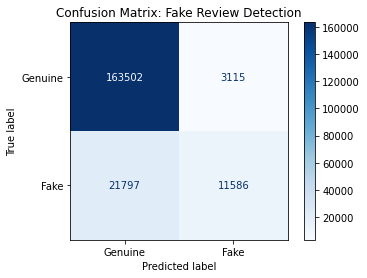


Model Limitations:
- Labels are based on heuristics, not true ground truth.
- Model may not generalize to more sophisticated or subtle fake reviews.
- Class imbalance may affect recall/precision for the 'fake' class.
- Only text features (TF-IDF) are used; metadata and behavioral features could improve results.
- Logistic Regression is a linear model; more complex relationships may not be captured.



In [ ]:
# Summarize findings
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Fake Review Detection")
plt.show()

# Document model limitations
print("""
Model Limitations:
- Labels are based on heuristics, not true ground truth.
- Model may not generalize to more sophisticated or subtle fake reviews.
- Class imbalance may affect recall/precision for the 'fake' class.
- Only text features (TF-IDF) are used; metadata and behavioral features could improve results.
- Logistic Regression is a linear model; more complex relationships may not be captured.
""")

### More features & cross-validation

In [13]:
# from sklearn.model_selection import cross_val_score

# # Example: Add review length as a feature
# df["review_length"] = df["text"].apply(len)
# X_text = vectorizer.fit_transform(df["text"])
# import numpy as np
# X = np.hstack([X_text.toarray(), df[["review_length"]].values])

# # Cross-validation
# scores = cross_val_score(clf, X, df["heuristic_label"], cv=5, scoring="f1")
# print("Cross-validated F1 scores:", scores)
# print("Mean F1 score:", scores.mean())

In [16]:
print(df["heuristic_label"].value_counts())

0    832409
1    167591
Name: heuristic_label, dtype: int64


In [ ]:

# Vectorize text
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df["text"])
df["review_length"] = df["text"].apply(len)
import numpy as np
X = hstack([X_text, np.array(df[["review_length"]])])
y = df["heuristic_label"]

# Train and cross-validate on the combined features
clf = LogisticRegression(max_iter=200, solver="saga", n_jobs=-1)
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("Cross-validated F1 scores:", scores)
print("Mean F1 score:", scores.mean())

Cross-validated F1 scores: [0. 0. 0. 0. 0.]
Mean F1 score: 0.0


In [19]:
clf = LogisticRegression(max_iter=200, solver="saga", n_jobs=-1, class_weight="balanced")
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("Cross-validated F1 scores:", scores)
print("Mean F1 score:", scores.mean())

Cross-validated F1 scores: [0.12754675 0.2657689  0.28863196 0.27062214 0.25278211]
Mean F1 score: 0.2410703731429174


In [20]:
clf.fit(X, y)
preds = clf.predict(X)
print(np.unique(preds, return_counts=True))

C:\Users\albin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(array([0, 1]), array([971982,  28018], dtype=int64))


### LightGBM

In [ ]:
lgbm = lgb.LGBMClassifier(class_weight="balanced", n_jobs=-1)
scores = cross_val_score(lgbm, X, y, cv=5, scoring="f1")
print("LightGBM Cross-validated F1 scores:", scores)
print("Mean F1 score:", scores.mean())

[LightGBM] [Info] Number of positive: 134073, number of negative: 665927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.980339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255197
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 1001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 134073, number of negative: 665927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.058822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255209
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 1001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscor